<a href="https://colab.research.google.com/github/p16111121/fcc_cat_dgg_test/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                            directory=train_dir,
                                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                            class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              shuffle = False)

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                        directory= PATH, classes=['test'],
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        class_mode = None,
                                                        shuffle = False
                                                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


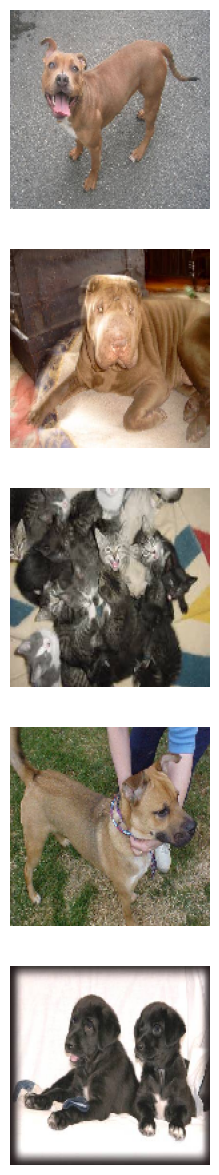

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [17]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=20,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           fill_mode = 'nearest')


Found 2000 images belonging to 2 classes.


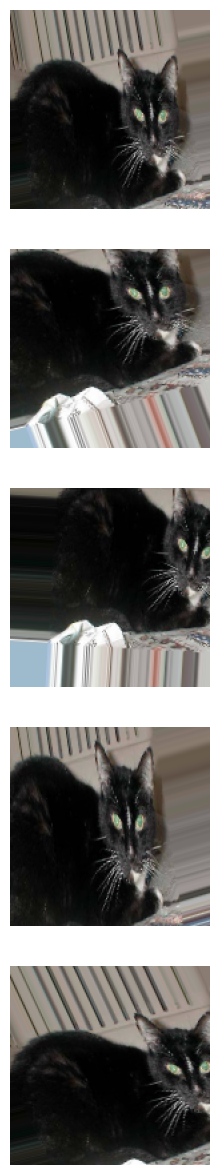

In [18]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [27]:
# 7
model = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),  # Add batch normalization
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Fully Connected Layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(256, activation='relu'),
    Dropout(0.4),  # Prevent overfitting

    # Output Layer
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification

])

# Compile the model
model.compile(
    optimizer= 'adam',                 # Adam optimizer
    loss='binary_crossentropy',       # Binary Cross Entropy loss for binary classification
    metrics=['accuracy']              # Track accuracy during training
)

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 148, 148, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 72, 72, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 72, 72, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 34, 34, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 34, 34, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 15, 15, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 15, 15, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,531,969 (55.44 MB)

 Trainable params: 14,530,049 (55.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch = train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps = val_data_gen.samples // batch_size
)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 472s 31s/step - accuracy: 0.4980 - loss: 4.7008 - val_accuracy: 0.5737 - val_loss: 0.7631
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 314ms/step - accuracy: 0.4844 - loss: 2.7607 - val_accuracy: 0.0000e+00 - val_loss: 2.4022
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 468s 31s/step - accuracy: 0.5296 - loss: 3.2685 - val_accuracy: 0.5290 - val_loss: 0.8785
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 420ms/step - accuracy: 0.5156 - loss: 3.4859 - val_accuracy: 0.1058 - val_loss: 1.7761
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 476s 31s/step - accuracy: 0.5417 - loss: 2.6718 - val_accuracy: 0.5569 - val_loss: 1.0066
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - accuracy: 0.5500 - loss: 2.6931 - val_accuracy: 0.0096 - val_loss: 1.8942
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 475s 31s/step - accuracy: 0.5104 - loss: 2.0708 - val_accuracy: 0.5580 - val_loss: 1.2401
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 737ms/step - accuracy: 0.5547 - loss: 1.4988 - val_accu

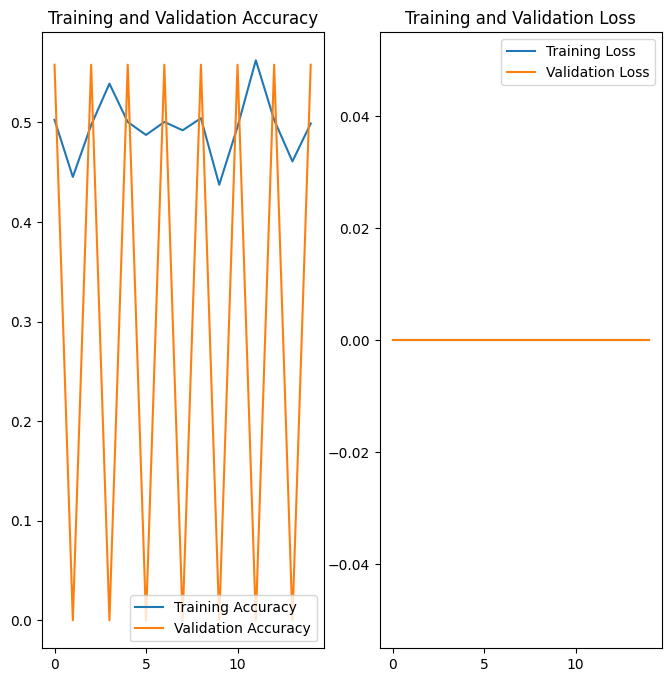

In [21]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# 10
probabilities = model.predict(test_data_gen, steps=test_data_gen.samples // batch_size)
print(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[0.0000000e+00]
 [3.7413111e-20]
 [0.0000000e+00]
 [1.2208882e-20]
 [1.0774553e-05]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.3910177e-15]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.5446859e-22]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.7724733e-38]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]


<ipython-input-4-e7cffa4c9536>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")


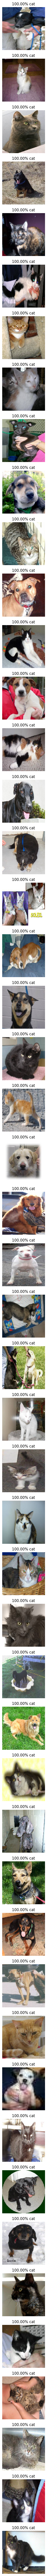

In [23]:
test_images = next(test_data_gen)
#probabilities_test = probabilities[:, 1]
plotImages(test_images,probabilities)

In [24]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 52.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
